In [0]:
from IPython.display import clear_output
!rm -rf *
!wget https://github.com/PvtSec/weatherML/raw/84eedf65cd5a4e2e089464a50e0b4c01d06fc719/Dataset/Delhi-Hourly/clean2.csv -O weather_data.csv
!clear
clear_output()
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6323193f-9087-591c-aeba-7ee5d6c65eee)


In [0]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import pandas as pd
import numpy as np
import tempfile
import os



#set output graph diamension
rcParams['figure.figsize'] = 20, 7

data = pd.read_csv("weather_data.csv")
temp_data_init = data['temperature']
temp_data_init.index = data['Index']

split = 100000
temp_data = temp_data_init.values
temp_mean = temp_data[:split].mean()
temp_stdv = temp_data[:split].std()
temp_std = (temp_data - temp_mean) / temp_stdv


past_data = 99000
target_data = 0

data = []
labels = []

start_index = 0 + past_data
end_index = split

for i in range(start_index, end_index):
  index = range(i-past_data, i)
  data.append(np.reshape(temp_std[index], (past_data, 1)))
  labels.append(temp_std[i+target_data])
x,y = np.array(data), np.array(labels)

def create_time_steps(length):
  return list(range(-length, 0))

train_univariate = tf.data.Dataset.from_tensor_slices((x, y))
train_univariate = train_univariate.cache().shuffle(256).batch(450).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x, y))
val_univariate = val_univariate.batch(256).repeat()

lstm = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=x.shape[-2:]), tf.keras.layers.Dense(1)])
lstm.compile(optimizer='adam', loss='mae')

In [0]:
EVALUATION_INTERVAL = 100
EPOCHS = 5
lstm.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

In [0]:
for xx, yy in val_univariate.take(1):
  print(xx)
  plot_data = [xx[0].numpy(), yy[0].numpy()]
  delta = 0
  labels = ['Previous values', 'Next Real value', 'Predicted value']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  tymstp = time_steps
  if delta:
    future = delta
  else:
    future = 0
  flatend_data = plot_data[0].flatten()

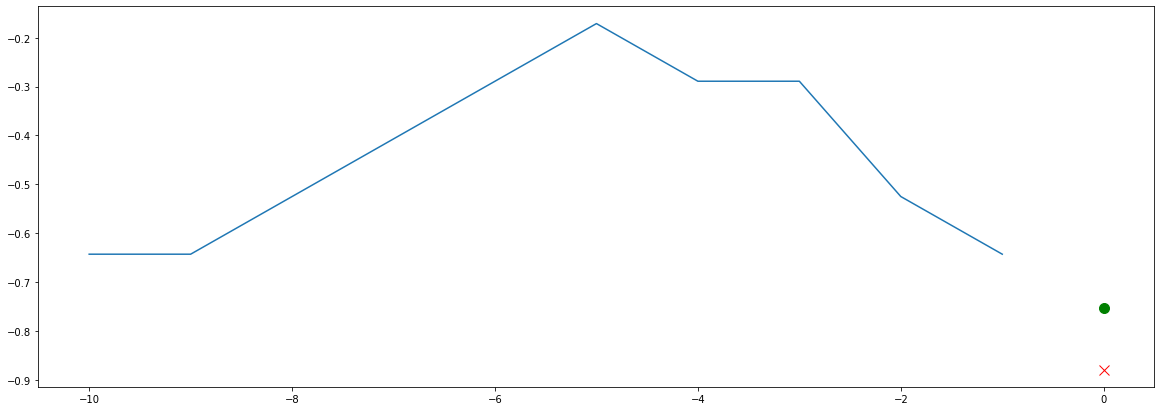

In [0]:
past=-10
ysmoothed = gaussian_filter1d(flatend_data, sigma=2)

xpoint = tymstp[past:]
ypoint = flatend_data[past:]
ysmoot = ysmoothed[past:]
plt.plot(xpoint,ypoint)
plt.plot(future, plot_data[1], marker[1], markersize=10, label=labels[1])
plt.plot(future, plot_data[2], marker[2], markersize=10, label=labels[2])

In [0]:
std_real_future = plot_data[1]
std_pred_future = plot_data[2][0]
#convert standardized value back to temperature
actual = abs((std_real_future * temp_stdv)+temp_mean)
predicted = abs((std_pred_future * temp_stdv)+temp_mean)
error = abs(round(((actual - predicted) / actual)*100,2))
print("Actual    :",round(actual,2),"°C")
print("Predicted :",round(predicted,2),"°C")
print("Error     :",error,"%")

In [0]:
export_path = "/content/agro_model"
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    lstm,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!zip -r agro_model.zip agro_model